### FINM33601 - Fixed Income Derivatives
## Homework 3
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: May 6th, 2021

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import quandl
import datetime as dt
import functools
import os
from tqdm import tqdm
import copy
import time
from scipy.stats import norm
from scipy.optimize import least_squares
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn import linear_model
%matplotlib inline
pd.set_option("precision", 4)
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
plt.style.use('fivethirtyeight')

# 1. Data

In [3]:
df  = pd.read_csv("Statistical Model_StatisticalModelData2020.csv").set_index(["DATE"])
df.index = pd.to_datetime(df.index)
df.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
DATE,,,,,,,
1981-01-05,13.52,13.09,12.289,12.28,12.294,12.152,11.672
1981-01-06,13.58,13.16,12.429,12.31,12.214,12.112,11.672
1981-01-07,14.50,13.90,12.929,12.78,12.614,12.382,11.892
1981-01-08,14.76,14.00,13.099,12.95,12.684,12.352,11.912
1981-01-09,15.20,14.30,13.539,13.28,12.884,12.572,12.132


# 2. PCA

In [4]:
pca = PCA(svd_solver='full')
pca.fit(df)
print('Explained variance by factors:\n', pca.explained_variance_.round(1))

Explained variance by factors:
 [80.8  1.5  0.1  0.   0.   0.   0. ]


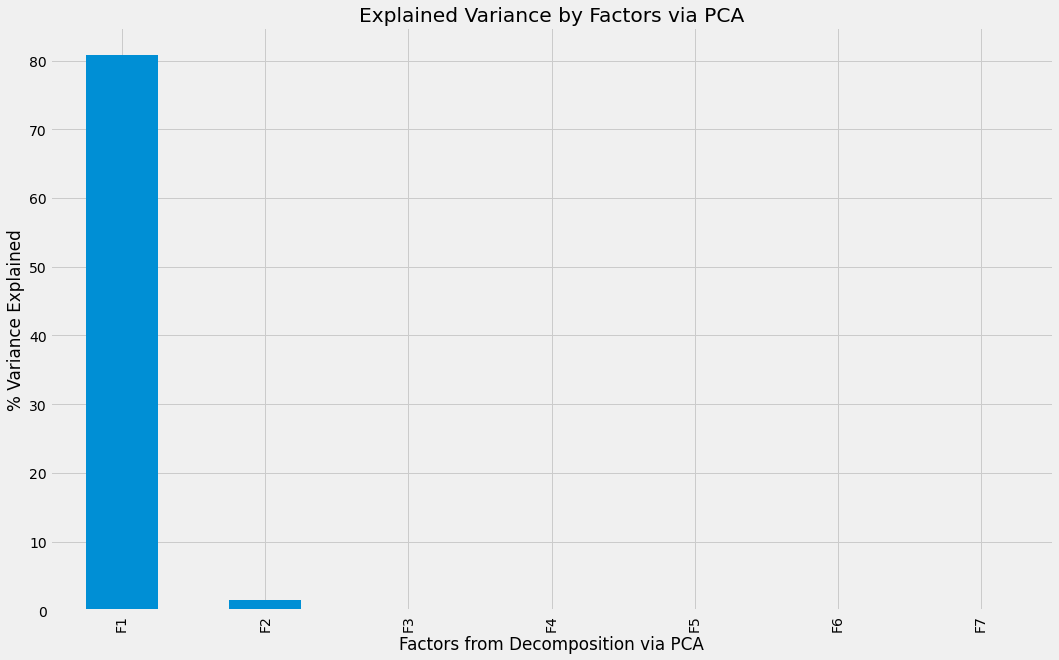

In [5]:
plt.figure()
pd.Series(pca.explained_variance_, index = ['F'+str(i) for i in range(1,8)]).plot(kind='bar')
plt.title("Explained Variance by Factors via PCA")
plt.ylabel("% Variance Explained")
plt.xlabel("Factors from Decomposition via PCA")
plt.show()

In [6]:
pca_factors = pd.DataFrame(pca.transform(df), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=df.index)
pca_factors.head()

,pca.f1,pca.f2,pca.f3,pca.f4,pca.f5,pca.f6,pca.f7
DATE,,,,,,,
1981-01-05,19.5643,2.2846,1.3997,-0.3332,-0.3021,-0.0181,0.0537
1981-01-06,19.6384,2.3987,1.3879,-0.2440,-0.2116,0.0263,0.0376
1981-01-07,20.9887,2.9213,1.5918,-0.3281,-0.2107,-0.0036,0.0504
1981-01-08,21.2867,3.1047,1.5815,-0.3885,-0.0910,-0.0287,0.0715
1981-01-09,22.1081,3.2539,1.6056,-0.3852,0.0536,0.0371,0.0585


<Figure size 1152x720 with 0 Axes>

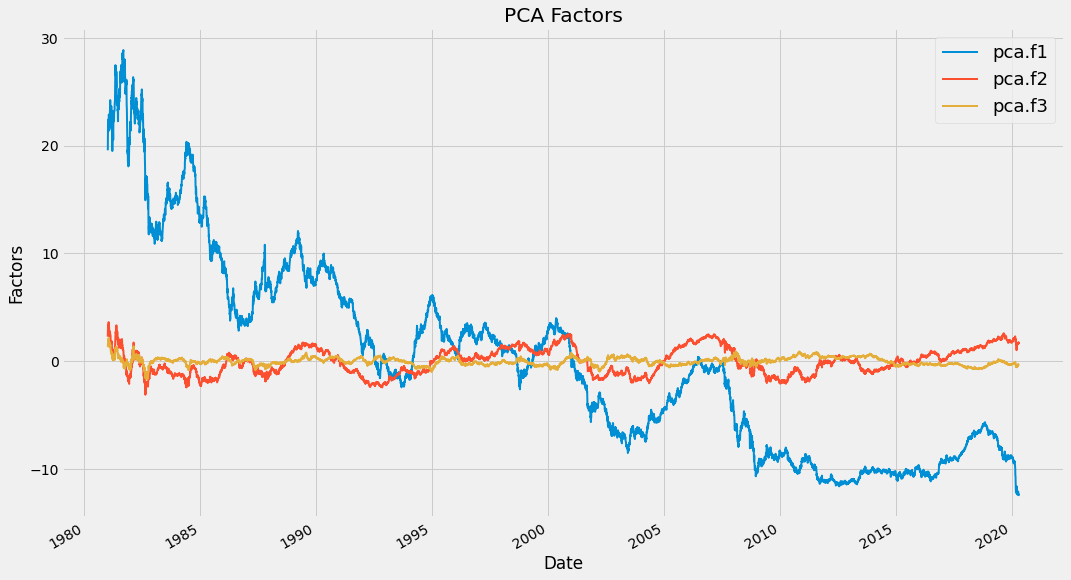

In [7]:
plt.figure()
pca_factors[['pca.f1', 'pca.f2', 'pca.f3']].plot(lw=2);
plt.title("PCA Factors")
plt.ylabel("Factors")
plt.xlabel("Date")
plt.legend(fontsize = 18)
plt.show()

In [8]:
maturities = pd.DataFrame({'maturities':[0.25,0.5,2,3,5,10,30]})
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings = pca_loadings.transpose()
pca_loadings.columns = ['pca.l{}'.format(i+1) for i in range(pca.n_components_)]
pca_loadings = maturities.join(pca_loadings)
pca_loadings.set_index("maturities", inplace = True)

In [9]:
pca_loadings

,pca.l1,pca.l2,pca.l3,pca.l4,pca.l5,pca.l6,pca.l7
maturities,,,,,,,
0.25,0.3799,0.4968,0.5199,-0.5128,0.2649,0.0729,0.0100
0.50,0.3883,0.4334,0.1552,0.5640,-0.5394,-0.1623,0.0429
2.00,0.4081,0.1391,-0.4117,0.2896,0.4560,0.3114,-0.5057
3.00,0.4022,0.0014,-0.4516,-0.0605,0.1906,-0.1079,0.7633
5.00,0.3858,-0.2128,-0.2841,-0.4625,-0.3422,-0.4907,-0.3916
10.00,0.3557,-0.4347,0.1342,-0.1179,-0.3841,0.7062,0.0793
30.00,0.3182,-0.5584,0.4831,0.3217,0.3605,-0.3466,0.0057


PCA loadings: 
             pca.l1  pca.l2  pca.l3  pca.l4
maturities                                
0.25        0.3799  0.4968  0.5199 -0.5128
0.50        0.3883  0.4334  0.1552  0.5640
2.00        0.4081  0.1391 -0.4117  0.2896
3.00        0.4022  0.0014 -0.4516 -0.0605
5.00        0.3858 -0.2128 -0.2841 -0.4625
10.00       0.3557 -0.4347  0.1342 -0.1179
30.00       0.3182 -0.5584  0.4831  0.3217


<Figure size 1152x720 with 0 Axes>

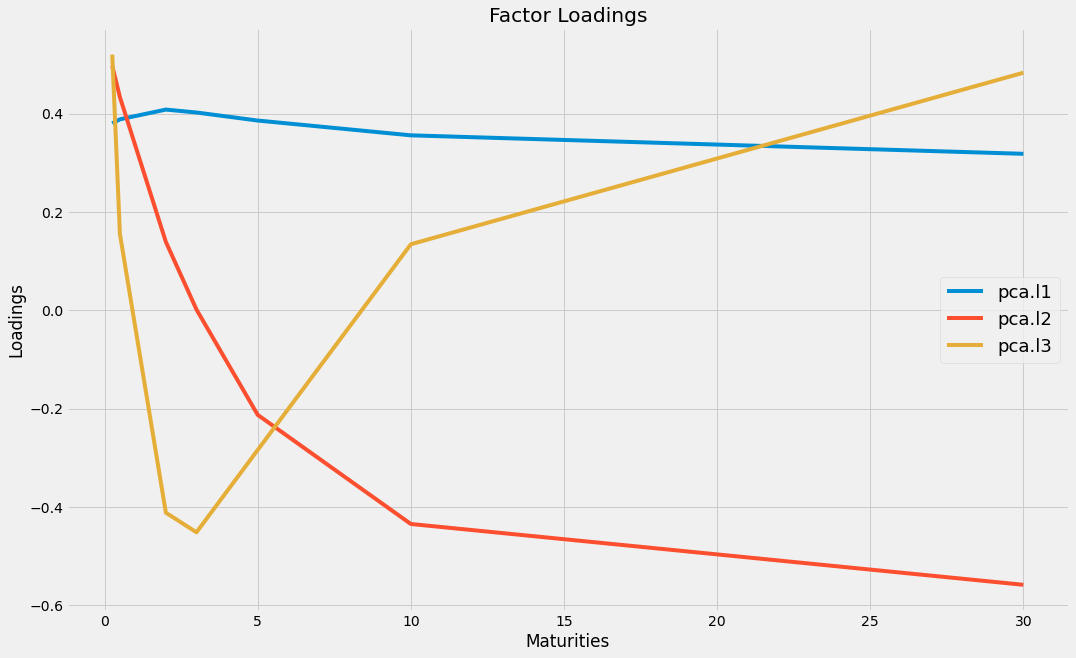

In [10]:
plt.figure()
print('PCA loadings: \n',pca_loadings.iloc[:,0:4])
pca_loadings[['pca.l1','pca.l2', 'pca.l3']].plot()
plt.title("Factor Loadings")
plt.ylabel("Loadings")
plt.xlabel("Maturities")
plt.legend(fontsize = 18)
plt.show()

Interpretation of plots in PDF

# 3. Historical Volatilities

Factors Correlation and Standard Deviations.

In [11]:
print("Correlation Matrix Factors Using Whole Data for the First 3 Factors")
pca_factors[['pca.f{}'.format(i) for i in range(1,4)]].corr()

Correlation Matrix Factors Using Whole Data for the First 3 Factors


,pca.f1,pca.f2,pca.f3
pca.f1,1.0000e+00,8.3347e-16,1.0000e-15
pca.f2,8.3347e-16,1.0000e+00,2.0248e-16
pca.f3,1.0000e-15,2.0248e-16,1.0000e+00


In [12]:
print("Standard Deviations Factors Using Whole Data for the First 3 Factors")
pca_factors[['pca.f{}'.format(i) for i in range(1,4)]].std().to_frame()

Standard Deviations Factors Using Whole Data for the First 3 Factors


,0
pca.f1,8.9892
pca.f2,1.2306
pca.f3,0.3592


Factors Differiation 

In [13]:
pca_factors_diff = pca_factors.diff().dropna()
pca_factors_diff.head()

,pca.f1,pca.f2,pca.f3,pca.f4,pca.f5,pca.f6,pca.f7
DATE,,,,,,,
1981-01-06,0.0741,0.1141,-0.0118,0.0892,0.0904,0.0444,-0.0161
1981-01-07,1.3503,0.5227,0.2039,-0.0841,0.0009,-0.0299,0.0129
1981-01-08,0.2980,0.1834,-0.0103,-0.0604,0.1196,-0.0251,0.0210
1981-01-09,0.8213,0.1492,0.0241,0.0034,0.1447,0.0658,-0.0130
1981-01-12,-0.4274,0.0453,0.3093,-0.0567,-0.0997,-0.0466,-0.0235


## 3.1 Whole Period History Correlation and Covariance Matrix for Factor Differientiation

In [14]:
print("Covariance Matrix Factor Differientiation Using Whole Data for the First 3 Factors")
pca_factors_diff[['pca.f{}'.format(i) for i in range(1,4)]].cov()

Covariance Matrix Factor Differientiation Using Whole Data for the First 3 Factors


,pca.f1,pca.f2,pca.f3
pca.f1,0.0300,-0.0001,-0.0004
pca.f2,-0.0001,0.0054,0.0018
pca.f3,-0.0004,0.0018,0.0023


In [15]:
print("Correlation Matrix Factor Differientiation Using Whole Data for the First 3 Factors")
pca_factors_diff[['pca.f{}'.format(i) for i in range(1,4)]].corr()

Correlation Matrix Factor Differientiation Using Whole Data for the First 3 Factors


,pca.f1,pca.f2,pca.f3
pca.f1,1.0000,-0.0096,-0.0469
pca.f2,-0.0096,1.0000,0.5234
pca.f3,-0.0469,0.5234,1.0000


In [16]:
print("Standard Deviations Factors Differentiation Using Whole Data for the First 3 Factors")
pca_factors_diff[['pca.f{}'.format(i) for i in range(1,4)]].std().to_frame()

Standard Deviations Factors Differentiation Using Whole Data for the First 3 Factors


,0
pca.f1,0.1732
pca.f2,0.0734
pca.f3,0.0478


## 3.2 Rolling Window Analysis

In [17]:
pca_rolling = pca_factors_diff[['pca.f{}'.format(i) for i in range(1,4)]].rolling(30)
pca_rolling_std = pca_rolling.std().dropna()
pca_rolling_var = pca_rolling.var().dropna()
pca_rolling_pair_corr = pd.DataFrame(data = None, index = pca_factors_diff.index, columns = ['Factor1/2', 'Factor1/3', 'Factor2/3'])
k = 0 
j = 1
for i in range(3):
    if i == 2:
        k = 1
        j = 2
    pca_rolling_pair_corr[pca_rolling_pair_corr.columns[i]] = pca_factors_diff[pca_factors_diff.columns[k]].rolling(30).corr(pca_factors_diff[pca_factors_diff.columns[j]])
    j += 1
pca_rolling_pair_corr.dropna(inplace = True)

In [18]:
pca_rolling_pair_corr

,Factor1/2,Factor1/3,Factor2/3
DATE,,,
1981-02-18,0.7067,0.3046,0.6297
1981-02-19,0.7348,0.3683,0.6639
1981-02-20,0.6756,0.3222,0.6317
1981-02-23,0.6324,0.2738,0.6461
1981-02-24,0.6123,0.2646,0.6460
...,...,...,...
2020-04-20,-0.7775,0.1414,0.0844
2020-04-21,-0.7820,0.0230,0.1420
2020-04-22,-0.8132,-0.1156,0.1957


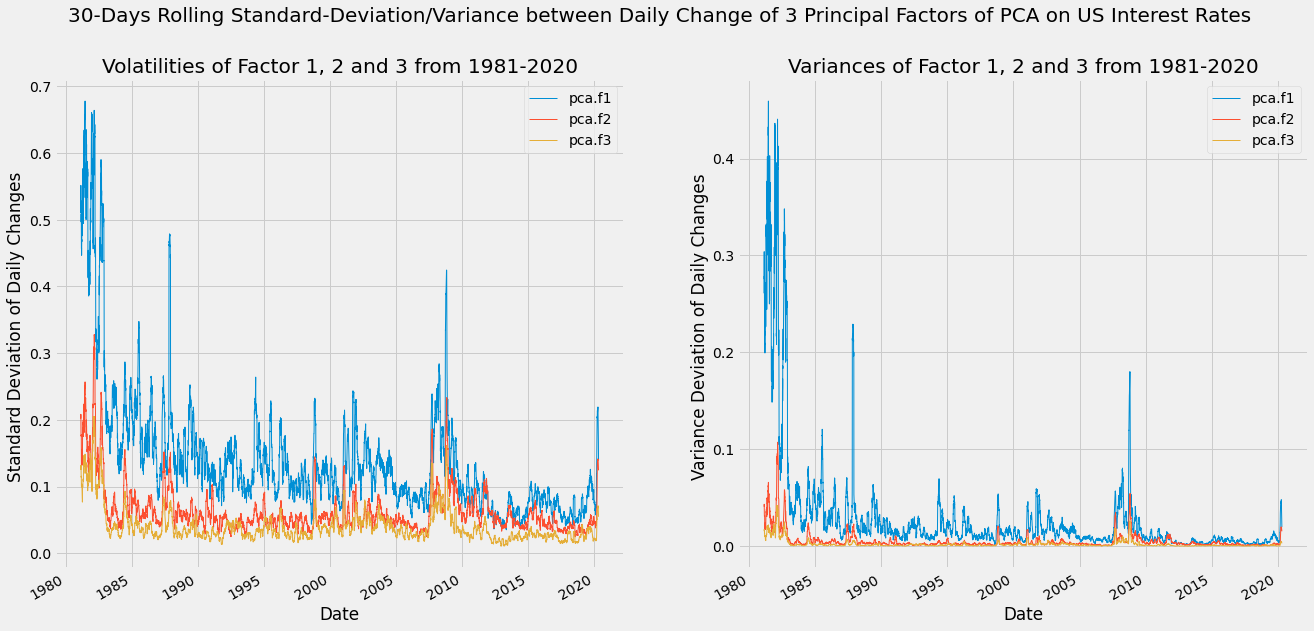

In [19]:
fig, axs = plt.subplots(1,2, figsize = (20,10))
fig.suptitle('30-Days Rolling Standard-Deviation/Variance between Daily Change of 3 Principal Factors of PCA on US Interest Rates', fontsize = 20)

pca_rolling_std.plot(ax = axs[0], lw = 1)
pca_rolling_var.plot(ax = axs[1], lw = 1)

axs[0].set_title("Volatilities of Factor 1, 2 and 3 from 1981-2020")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Standard Deviation of Daily Changes ")

axs[1].set_title("Variances of Factor 1, 2 and 3 from 1981-2020")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Variance Deviation of Daily Changes ")
plt.show()

<Figure size 1440x720 with 0 Axes>

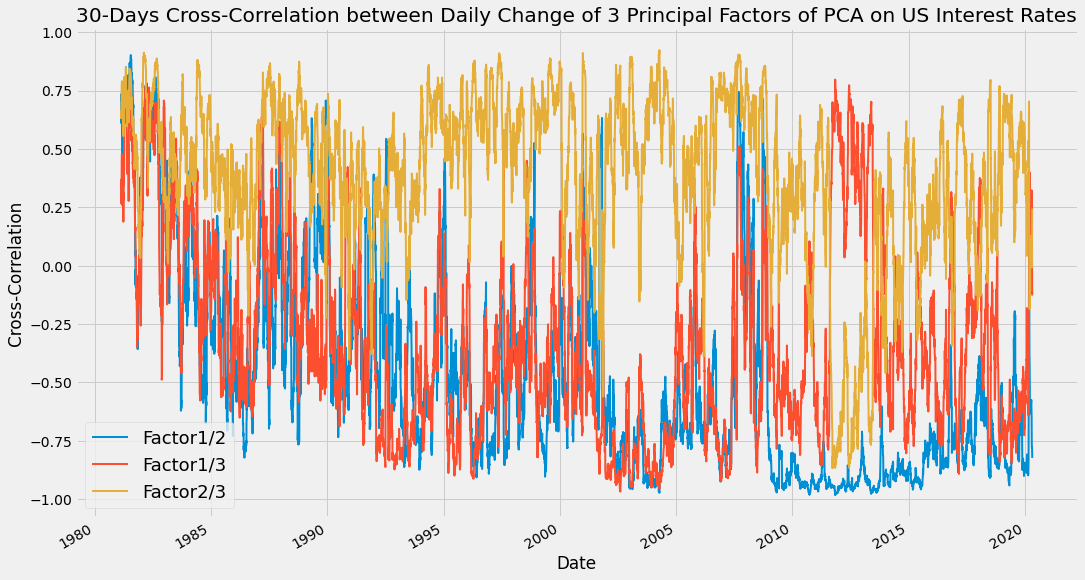

In [20]:
plt.figure(figsize=(20,10))
pca_rolling_pair_corr.plot(lw = 2)
plt.title("30-Days Cross-Correlation between Daily Change of 3 Principal Factors of PCA on US Interest Rates")
plt.ylabel("Cross-Correlation")
plt.xlabel("Date")
plt.legend(fontsize = 18)
plt.show()

This looks a little noisy let's individualize them.

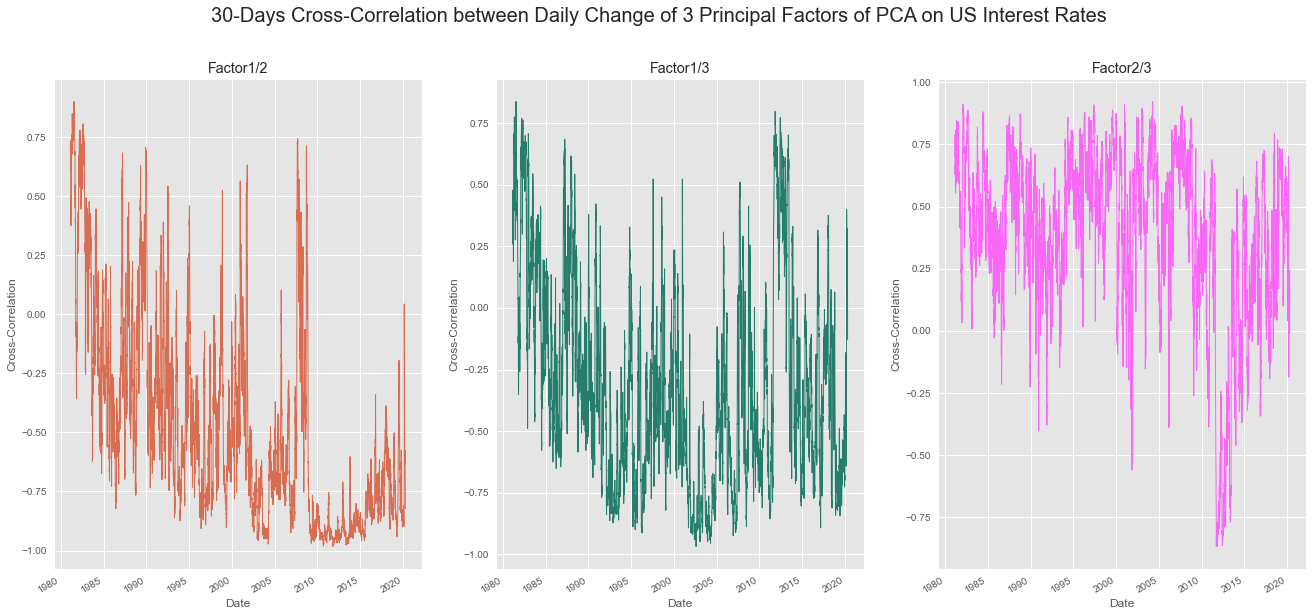

In [116]:
fig, axs = plt.subplots(1,3, figsize = (20,10))
fig.suptitle("30-Days Cross-Correlation between Daily Change of 3 Principal Factors of PCA on US Interest Rates", fontsize = 20)

for i,col in enumerate(pca_rolling_pair_corr.columns):
    pca_rolling_pair_corr[col].plot(ax = axs[i], lw=1, c=np.random.rand(3,))
    axs[i].set_title(col)
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Cross-Correlation")
plt.show()

# 4. Recent factor volatilities

In [22]:
last_day = pca_factors_diff.index[-1]
print("Last day in dataset is {}".format(last_day))

Last day in dataset is 2020-04-24 00:00:00


Let's look at the volatility of the three factors for the month of April in 2020.

In [23]:
df_april_2020 = pca_factors_diff[pca_factors_diff.index >= '2020-04-01'][['pca.f{}'.format(i) for i in range(1,4)]]
df_april_2020.head()

,pca.f1,pca.f2,pca.f3
DATE,,,
2020-04-01,-0.0694,0.0652,-0.0568
2020-04-02,0.0160,0.0013,-0.0121
2020-04-03,-0.0021,0.0205,-0.0103
2020-04-06,0.1098,-0.0100,-0.0030
2020-04-07,0.0758,-0.0618,0.0144


In [24]:
print("Standard Deviations Factors Differentiation Using Last Month Data (April 2020) for the First 3 Factors")
df_april_2020.std().to_frame()

Standard Deviations Factors Differentiation Using Last Month Data (April 2020) for the First 3 Factors


,0
pca.f1,0.0730
pca.f2,0.0472
pca.f3,0.0382


In [25]:
print("Correlation Matrix Factor Differientiation Using Last Month Data (April 2020)  for the First 3 Factors")
df_april_2020.corr()

Correlation Matrix Factor Differientiation Using Last Month Data (April 2020)  for the First 3 Factors


,pca.f1,pca.f2,pca.f3
pca.f1,1.0000,-0.7122,0.5265
pca.f2,-0.7122,1.0000,-0.3946
pca.f3,0.5265,-0.3946,1.0000


# 5. Prediction

In [26]:
pred_loadings = pca_loadings[pca_loadings.columns[:3]]

fitted_rates = pd.DataFrame(index = pca_factors.index, columns = df.columns)
for i, yield_term in enumerate(df.columns):
    fitted_rates[yield_term] = pca_factors[pca_factors.columns[:3]].values@pred_loadings.iloc[i] + df[yield_term].mean()
fitted_rates.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
DATE,,,,,,,
1981-01-05,13.4300,13.1098,12.5560,12.2745,12.0487,12.0052,11.8815
1981-01-06,13.5086,13.1861,12.6070,12.3097,12.0564,11.9804,11.8357
1981-01-07,14.3873,13.9687,13.1467,12.7614,12.4081,12.2609,12.0720
1981-01-08,14.5863,14.1623,13.2981,12.8862,12.4870,12.2858,12.0594
1981-01-09,14.9850,14.5497,13.6441,13.2058,12.7653,12.5164,12.2491


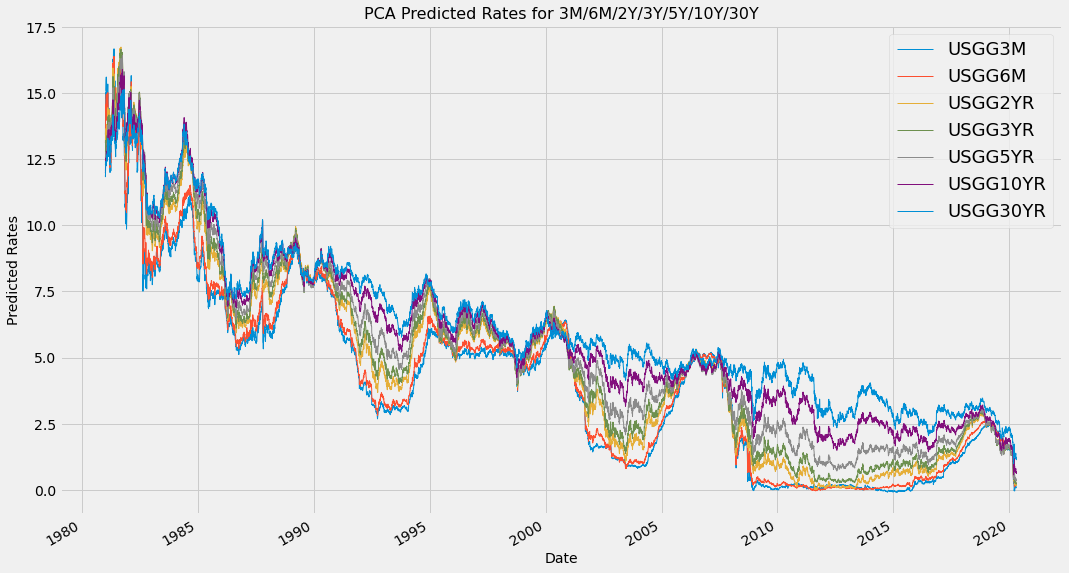

In [27]:
fitted_rates.plot(lw = 1)
plt.title('PCA Predicted Rates for 3M/6M/2Y/3Y/5Y/10Y/30Y', size = 16)
plt.ylabel('Predicted Rates', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()

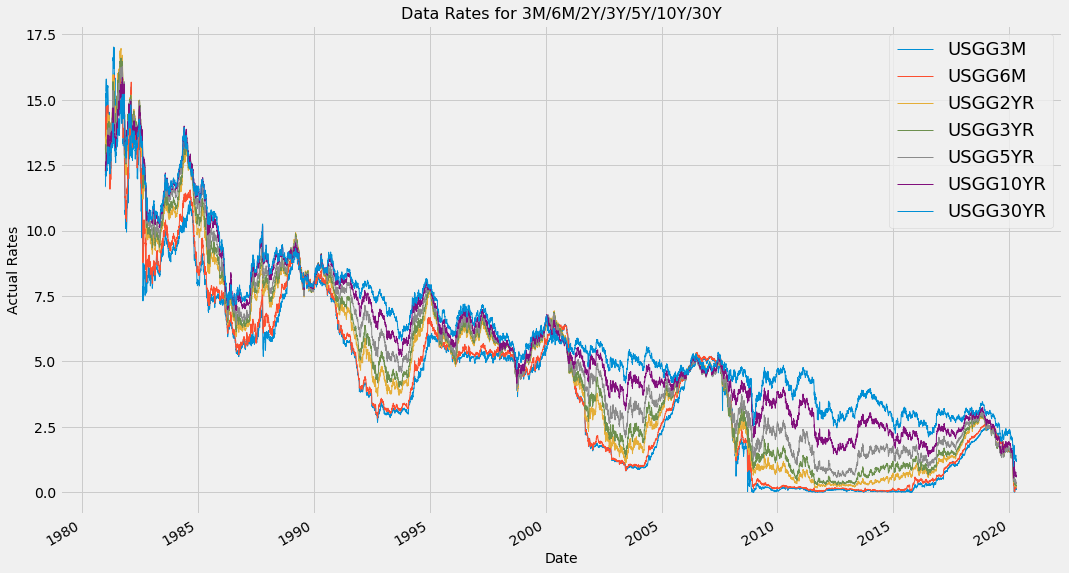

In [28]:
df.plot(lw = 1)
plt.title('Data Rates for 3M/6M/2Y/3Y/5Y/10Y/30Y', size = 16)
plt.ylabel('Actual Rates', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()

As we can tell, they are very similar one to each other.

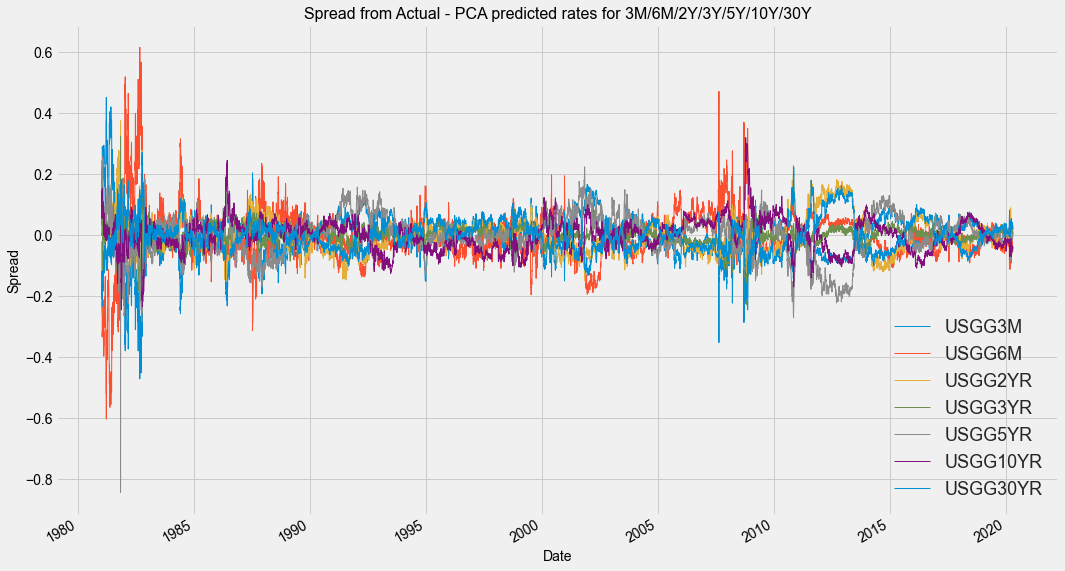

In [29]:
(df- fitted_rates).plot(lw = 1)
plt.title('Spread from Actual - PCA predicted rates for 3M/6M/2Y/3Y/5Y/10Y/30Y', size = 16)
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 10)
plt.ylabel('Spread', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()

This makes sense that the spread is highest in 1980s where the rates were the highest and around 2008 where the change of rates due to financial crises was abrute. 

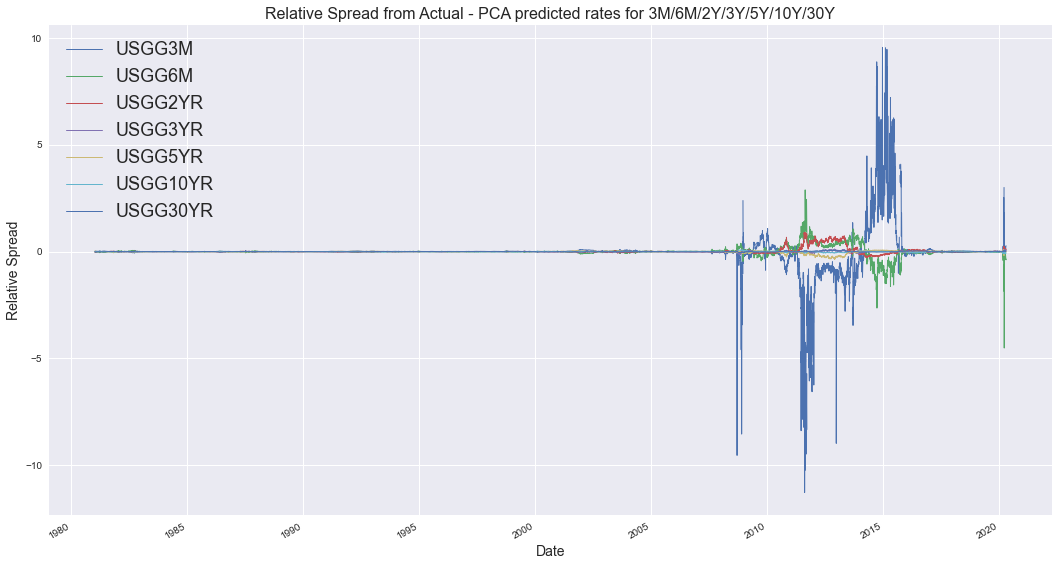

In [30]:
((df- fitted_rates)/df).plot(lw = 1)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)
plt.title('Relative Spread from Actual - PCA predicted rates for 3M/6M/2Y/3Y/5Y/10Y/30Y', size = 16)
plt.ylabel('Relative Spread', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()

In [31]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('ggplot')

Here we say the relative different between the Actual - PCA, we observe that durring 2008 financial crisis was the period where the PCA had a relative error that was the largest and we also see a spike during April 2020. The lower term rates are the ones affected the most.

# 6. Parametric Loadings

In [32]:
pca_loadings

,pca.l1,pca.l2,pca.l3,pca.l4,pca.l5,pca.l6,pca.l7
maturities,,,,,,,
0.25,0.3799,0.4968,0.5199,-0.5128,0.2649,0.0729,0.0100
0.50,0.3883,0.4334,0.1552,0.5640,-0.5394,-0.1623,0.0429
2.00,0.4081,0.1391,-0.4117,0.2896,0.4560,0.3114,-0.5057
3.00,0.4022,0.0014,-0.4516,-0.0605,0.1906,-0.1079,0.7633
5.00,0.3858,-0.2128,-0.2841,-0.4625,-0.3422,-0.4907,-0.3916
10.00,0.3557,-0.4347,0.1342,-0.1179,-0.3841,0.7062,0.0793
30.00,0.3182,-0.5584,0.4831,0.3217,0.3605,-0.3466,0.0057


In [33]:
pca_loadings[pca_loadings.columns[1]].values

array([ 0.49675292,  0.4334371 ,  0.13909116,  0.00144862, -0.2127963 ,
       -0.4347041 , -0.55836408])

In [34]:
# ENRIQUE PEREZ HELPED ME TO FIGURE OUT THIS PART, CREDIT GOES TO HIM
def I_i_res(estimate, correct_values):
    res = []
    A,B = estimate[0:int(len(estimate)//2)] , estimate[int(len(estimate)//2):]
    tenors = [0.25,0.5,2,3,5,10,30]
    for count, t in enumerate(tenors):
        temp_sum = 0 
        for j in range(len(A)):
            a,b = A[j], B[j]
            temp_sum += (b/(a*t)) * (1 - np.exp(-a*t))
        res.append(temp_sum-correct_values[count])
    
    return res
    

In [35]:
res_list = []
# Setting a>0
I_0_res = lambda x: I_i_res(x, df.mean()) 
res0 = least_squares(I_0_res, [.65,.004,-1.13,.539], bounds = ([0,0,-np.inf,-np.inf],[np.inf for i in range(4)]))
res_list.append(res0)

I_1_res = lambda x: I_i_res(x, pca_loadings[pca_loadings.columns[0]].values) 
res1 = least_squares(I_1_res, [.32,.006,36.550,.07,.285,-.292], bounds = ([0,0,0,-np.inf,-np.inf,-np.inf],[np.inf for i in range(6)]))
res_list.append(res1)

I_2_res = lambda x: I_i_res(x, pca_loadings[pca_loadings.columns[1]].values) 
res2 = least_squares(I_2_res, [.65,.004,-1.13,.539], bounds = ([0,0,-np.inf,-np.inf],[np.inf for i in range(4)]))
res_list.append(res2)

I_3_res = lambda x: I_i_res(x, pca_loadings[pca_loadings.columns[2]].values) 
res3 = least_squares(I_3_res, [.42,.000000005,.05,2.876 ,-1.920,.62,-.410,3.035], bounds = ([0,0,0,0,-np.inf,-np.inf,-np.inf,-np.inf],[np.inf for i in range(8)]))
res_list.append(res3)

for i in range(len(res_list)):
    print('Results for loading {}: '.format(i))
    print('a :', np.round(res_list[i].x[:int(len(res_list[i].x)/2)],3))
    print('b :', np.round(res_list[i].x[int(len(res_list[i].x)/2):],3))


Results for loading 0: 
a : [0.394 0.   ]
b : [-2.395  6.452]
Results for loading 1: 
a : [ 0.141  0.    22.381]
b : [ 0.145  0.284 -0.284]
Results for loading 2: 
a : [0.016 0.397]
b : [-0.853  1.417]
Results for loading 3: 
a : [0.149 0.068 0.15  2.161]
b : [-3.434  3.749 -1.784  2.479]


# 7. Instantaneous forward rates

$$ F(t, \tau) = B_0'(\tau) + \sum_{i=1}^3 B_i'(\tau) \cdot f_i(t) $$

$$ B_i(\tau) = l_i(\tau)\tau =\tau\left[\sum_{j=1}^{m_i}b_{ij}\frac{1-\exp{(-a_{ij}\tau)}}{a_{ij} \tau}\right]$$

$$ B_i'(\tau) = \sum_{j=1}^{m_i}b_{ij}e^{-a_{ij}\tau)} $$ 
$$  F(t, \tau) = B_0(\tau) + \sum_{i=1}^3 \left(\sum_{j=1}^{m_i} b_{ij}e^{-a_{ij}\tau}\right) \cdot f_i(t) $$


In [36]:
def B_derivatives(param_loadings_lst, tenor):
    B = np.zeros(len(param_loadings_lst))
    for i, loadings in enumerate(param_loadings_lst):
        a = np.array(loadings.x[:int(len(loadings.x)/2)])
        b = np.array(loadings.x[int(len(loadings.x)/2):])
        B_i = b @ np.exp(-a * tenor)
        B[i] = B_i
    return B
B_der = B_derivatives(res_list, 5)
B_der

array([ 6.11703326,  0.35533236, -0.59251582,  0.19245871])

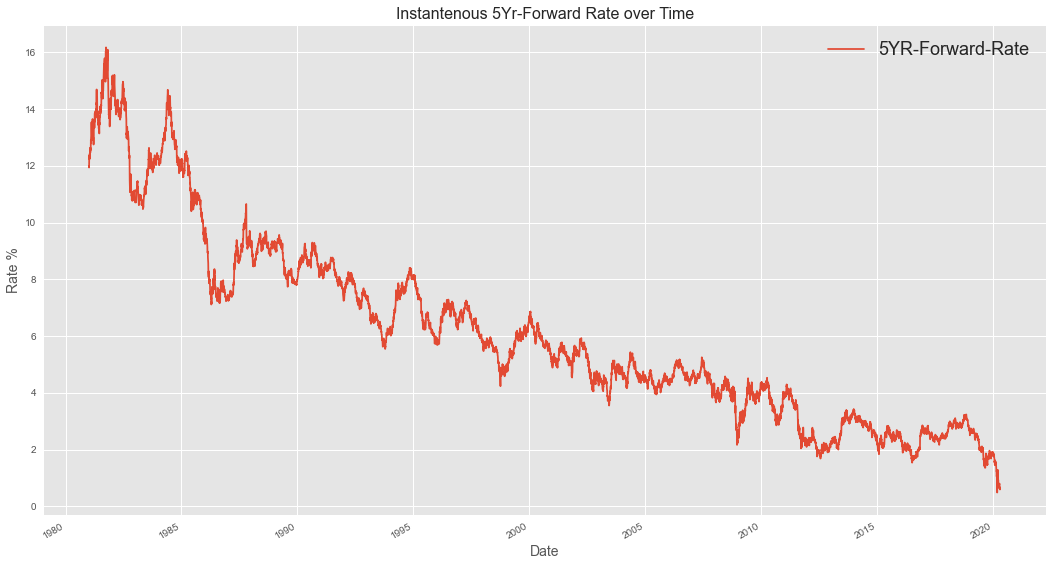

In [37]:
insta_forward_rate_df = pd.DataFrame(index = pca_factors.index, columns = ['5YR-Forward-Rate'])
insta_forward_rate_df['5YR-Forward-Rate'] = np.insert(pca_factors[pca_factors.columns[:3]].values,0,1,axis=1) @ B_der
insta_forward_rate_df.plot()
plt.title('Instantenous 5Yr-Forward Rate over Time', size = 16)
plt.ylabel('Rate %', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()


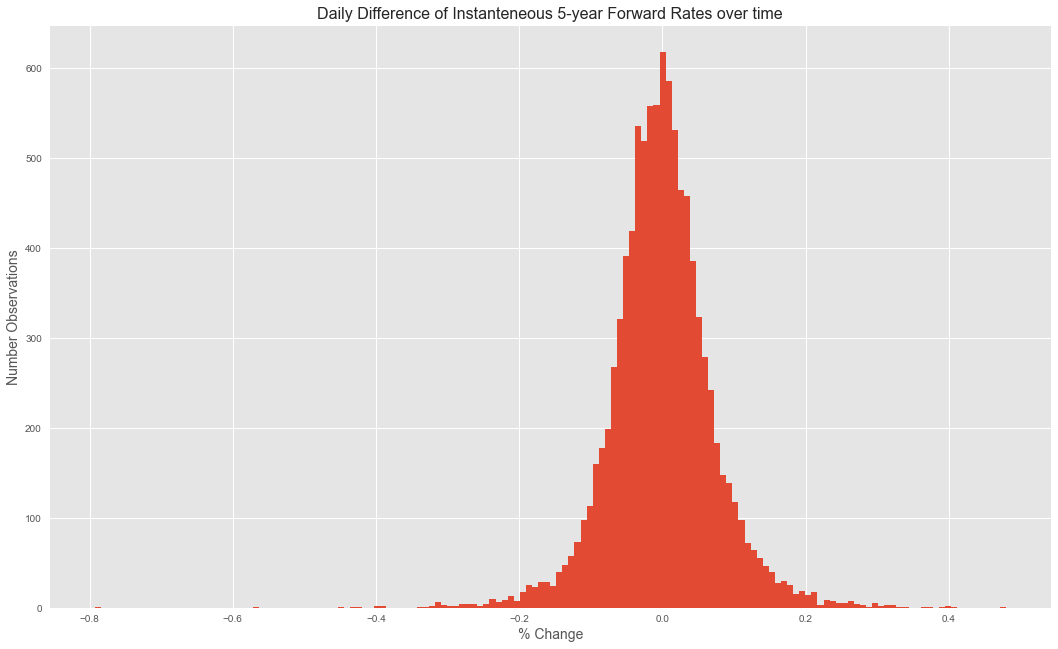

In [38]:
insta_forward_rate_df.diff().dropna().hist(bins = 150,figsize = (16,10))
plt.title('Daily Difference of Instanteneous 5-year Forward Rates over time', size = 16)
plt.ylabel('Number Observations', size = 14)
plt.xlabel('% Change', size = 14)

plt.show()

In [39]:
def B_i(param_loadings_lst, tenor):
    B = np.zeros(len(param_loadings_lst))
    for i, loadings in enumerate(param_loadings_lst):
        a = np.array(loadings.x[:int(len(loadings.x)/2)])
        b = np.array(loadings.x[int(len(loadings.x)/2):])
        B_i = (b @ ((1-np.exp(-a * tenor))/a))
        B[i] = B_i
    # Correct the first term since not multiplied by the tenor
    return B
B_45 = B_i(res_list, 4.5)
B_45

array([23.98322481,  1.74762699, -0.73262163, -1.42667418])

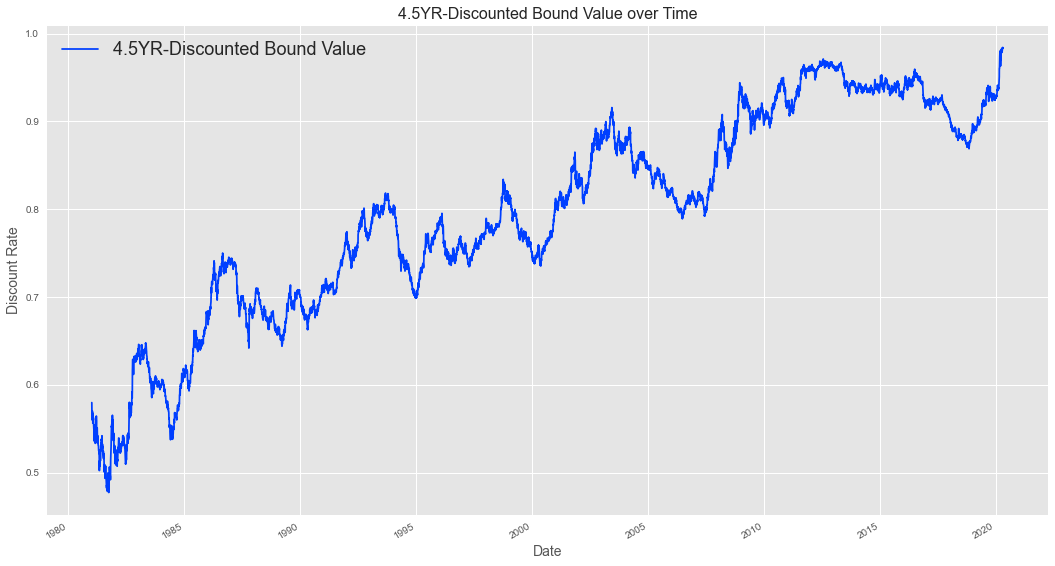

In [117]:
discount_bound_df = pd.DataFrame(index = pca_factors.index, columns = ['4.5YR-Discounted Bound Value'])
factor_arr =  np.insert(pca_factors[pca_factors.columns[:3]].values,0,1,axis=1)
discount_bound_df['4.5YR-Discounted Bound Value'] = np.exp(-(factor_arr/100 @ B_45))
discount_bound_df.plot()
plt.title('4.5YR-Discounted Bound Value over Time', size = 16)
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = (16, 10)
plt.ylabel('Discount Rate', size = 14)
plt.xlabel('Date', size = 14)
plt.legend(fontsize=18)
plt.show()

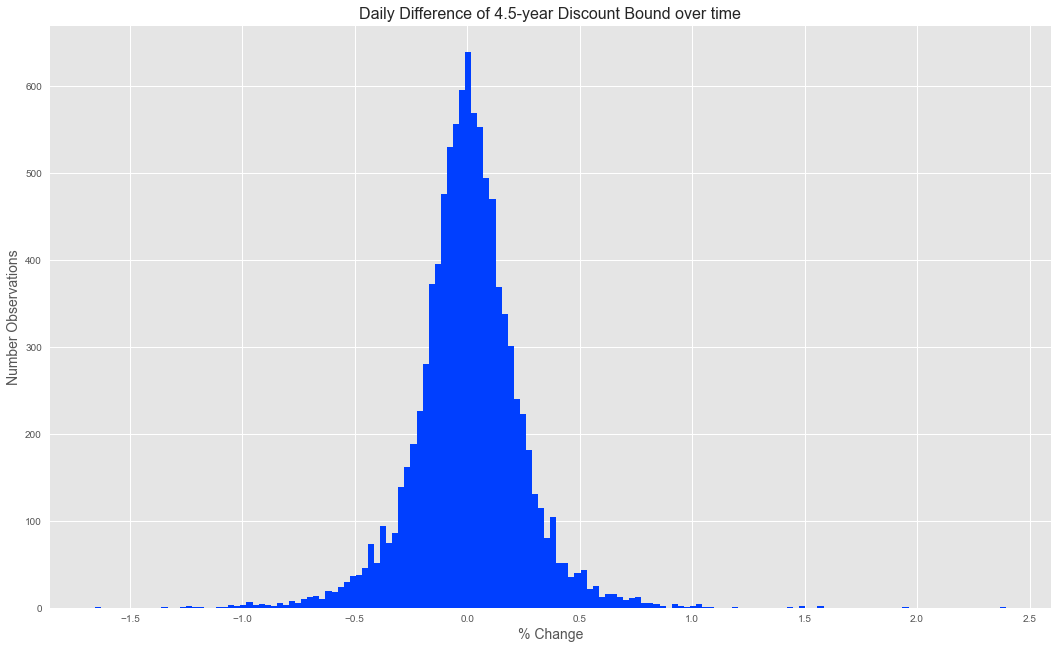

In [41]:
(100*discount_bound_df.diff()).dropna().hist(bins = 150,figsize = (16,10))
plt.title('Daily Difference of 4.5-year Discount Bound over time', size = 16)
plt.ylabel('Number Observations', size = 14)
plt.xlabel('% Change', size = 14)

plt.show()

# 8. Correlations between instantaneous rates

In [107]:
tenors = np.linspace(0,30,1000)

inst_fwd_dic = {}
inst_fwd_dic[3] = pd.DataFrame([np.insert(pca_factors[pca_factors.columns[:3]].values,0,1,axis=1) @ B_derivatives(res_list, t) for t in tenors]).T
inst_fwd_dic[2] = pd.DataFrame([np.insert(pca_factors[pca_factors.columns[:2]].values,0,1,axis=1) @ B_derivatives(res_list, t)[:3]  for t in tenors]).T
inst_fwd_dic[1] = pd.DataFrame([np.insert(pca_factors[pca_factors.columns[:1]].values,0,1,axis=1) @ B_derivatives(res_list, t)[:2] for t in tenors]).T


lst_corr_1 = []
lst_corr_2 = []
lst_corr_3 = []
lst_corr = [lst_corr_1, lst_corr_2, lst_corr_3]
for k in inst_fwd_dic.keys():
    inst_fwd_dic[k].columns = tenors
    inst_fwd_dic[k] = inst_fwd_dic[k].diff().dropna()

In [108]:
for c in list(inst_fwd_dic[1]):
    lst_corr_1.append(inst_fwd_dic[1][[0,c]].corr().iloc[0,1])
    lst_corr_2.append(inst_fwd_dic[2][[0,c]].corr().iloc[0,1])
    lst_corr_3.append(inst_fwd_dic[3][[0,c]].corr().iloc[0,1])

In [114]:
tenors = np.linspace(0.25,30,1000)
insta_future_spot_rates = pd.DataFrame(index = tenors, columns = ['1 Factor', '2 Factors', '3 Factors'])
for i in range(len(lst_corr)):
    insta_future_spot_rates[insta_future_spot_rates.columns[i]] = lst_corr[i]
    
insta_future_spot_rates.head()

,1 Factor,2 Factors,3 Factors
0.2500,1.0,1.0000,1.0000
0.2798,1.0,0.9416,0.9544
0.3096,1.0,0.8943,0.8936
0.3393,1.0,0.8678,0.8425
0.3691,1.0,0.8514,0.7982


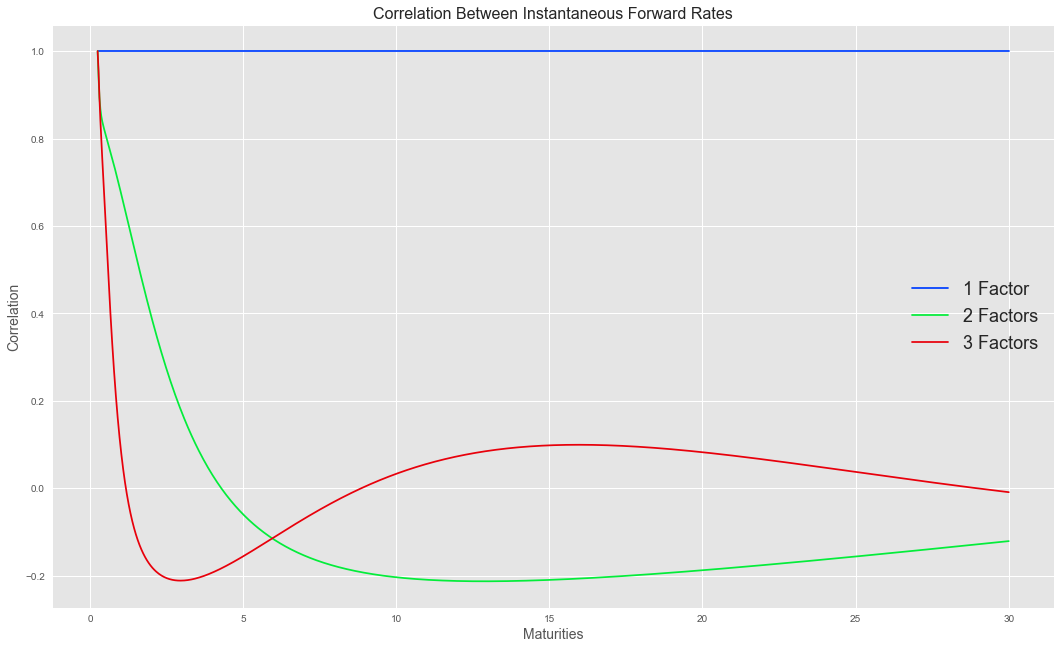

In [115]:
insta_future_spot_rates.plot()
plt.title('Correlation Between Instantaneous Forward Rates', size = 16)
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = (16, 10)
plt.ylabel('Correlation', size = 14)
plt.xlabel('Maturities', size = 14)
plt.legend(fontsize=18)
plt.show()

# 9. FRA Rate

In [46]:
res_list2 = []
res_list2.append([0.3667761,  0.0010000, -2.5020220,  6.5669031])
res_list2.append([0.1472244,  0.0010000, 36.5486585,  0.1379750,  0.2908608, -0.4631877])
res_list2.append([0.01618005,  0.39616503, -0.85466071,  1.41763272])
res_list2.append([0.20184969,  0.04078695,  0.20274699,  2.08203408, -2.47831969,  1.68864335, -0.75981332,  2.54790398])

In [47]:
FRA_rate = 0.02968021

In [122]:
april_2014_factors = pca_factors.loc['2014-04-17':'2014-04-21'][pca_factors.columns[:3]]
april_2014_factors

,pca.f1,pca.f2,pca.f3
DATE,,,
2014-04-17,-10.0496,-0.8433,0.1722
2014-04-21,-10.0499,-0.8333,0.1859


In [123]:
april_2014_factors = april_2014_factors.reset_index().drop('DATE',axis=1)
april_2014_factors['new_index'] = [-1,3]
april_2014_factors= april_2014_factors.set_index('new_index')
april_2014_factors

,pca.f1,pca.f2,pca.f3
new_index,,,
-1,-10.0496,-0.8433,0.1722
3,-10.0499,-0.8333,0.1859


In [49]:
factors = [] 
for col in april_2014_factors:
    xp = april_2014_factors.index.values
    fp = april_2014_factors[col].values
    factors.append(np.interp(0,xp,fp))
factors

[-10.049703142761613, -0.8407858018240437, 0.17561563643893818]

In [124]:
def B_i_v2(param_loadings_lst, tenor):
    B = np.zeros(len(param_loadings_lst))
    for i, loadings in enumerate(param_loadings_lst):
        a = np.array(loadings[:int(len(loadings)/2)])
        b = np.array(loadings[int(len(loadings)/2):])
        B_i = (b @ ((1-np.exp(-a * tenor))/a))
        B[i] = B_i
    # Correct the first term since not multiplied by the tenor
    return B

$$
F(t,\tau_1, \tau_2) = \frac{\left(B_0(\tau_2) - B_0(\tau_1)\right)}{\tau_2-\tau_1} + \sum_{i=1}^3 \frac{\left(B_i(\tau_2) - B_i(\tau_1)\right)}{\tau_2-\tau_1}\times f_i(t)
$$


In [58]:
B_2 = B_i_v2(res_list2, 9/12)
B_1 = B_i_v2(res_list2, 3/12)
delta_tau = 9/12 - 3/12
forward_rate = (1/delta_tau) * B_2 @ np.insert(factors,0,1) - B_1 @ np.insert(factors,0,1)
print("6 months Forward Rate starting in 3 months from 2014/04/18 using interpolation between 2014/04/17 and 2014/04/21 for factors = {:.4f}% ".format(forward_rate))

6 months Forward Rate starting in 3 months from 2014/04/18 using interpolation between 2014/04/17 and 2014/04/21 for factors = -0.0391% 
